### Домашнее задание 3 - 10 баллов

В этом задании вам предстоит продолжить работу с задачей машинного перевода из [занятия 7](https://github.com/pacifikus/itmo_dl_nlp_course/blob/main/Lecture%207/itmo_dl_nlp_course_06_seq2seq.ipynb)

Попробуйте улучшить качество модели, проверив следующие гипотезы:

- измените размер словаря / предобработку во время токенизации - **1 балл**
- продолжите эксперименты с различными RNN юнитами в encoder и decoder части: замена GRU/LSTM, изменение количества слоев, использование bidirectional RNN - **1 балл**
- улучшите процесс тренировки: добавьте lr sheduling, early stopping, поэкспериментируйте с оптимизатором - **2 балла**
- поэкспериментируйте с сэмплированием - замените greedy-инференс на альтернативные варианты - **2 балла**
- проведите ablation-study, сделайте выводы о влиянии ваших изменений на итоговую производительность модели - **2 балла**


**Задание выполнялось в Google Colab**

На занятии наилучшей моделью была версия с **Attention** и максимальное полученное значение метрики **BLEU** для неё равнялось 24. Будем отталкиваться от неё и выполним следующие шаги:

- Увеличим размер словаря токенизатора до 10000 токенов  
- Заменим все реккурентные модули на GRU. GRU использует 2 гейта вместо 3 (как в LSTM), что обеспечит нам более быстрые вычисления и меньшую нагрузку на память, при этом качество перевода должно сохранится хорошим
- Используем bidirectional RNN для более глубокого захвата контекста
- Оптимизатор Adam меняем на AdamW для улучшения регуляризации и снижения переобучения
- Добавим косинусный lr-планировщик с разогревом (warmup) для улучшения сходимости
- Добавим early stopping для предотвращения переобучения при отсутствии улучшений метрики
- Добавлено top_k и top_p сэмплирование с регулировкой температуры для разнообразия генерация и замены greedy-инференса

In [1]:
!pip install subword-nmt

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split
from vocab import Vocab

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
from transformers import get_cosine_schedule_with_warmup

%matplotlib inline

**Загрузка данных**

In [4]:
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt

--2025-03-20 11:17:47--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2025-03-20 11:17:48--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb19ef7c7f102fd802a3eb4b642.dl.dropboxusercontent.com/cd/0/inline/CmN-vf5b0NcgvlSIcZVifTp5XDmXQ2_5tGparJnw-SVap4dQRG4cc3zsOXfYBfCbgJD4ii6IulARyPySX5o0Pq4gbu7SsRRzT-vMw2no7mw6TnCGdtwQuz5N2ZVbOnthlJs/file?dl=1# [following]
--2025-03-20 11:17:48--  https://ucb19ef7c7f102fd802a3eb4b642.dl.dropboxusercontent.com/cd/0/inline/CmN-vf5b0Ncgvl

**Фиксация сида для воспроизводимости ноутбука**

In [5]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

**BPE**

In [16]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))

with open('train.en', 'w', encoding='utf-8') as f_src,  open('train.ru', 'w', encoding='utf-8') as f_dst:
  for line in open('data.txt', "r", encoding='utf-8'):
    src_line, dst_line = line.strip().split('\t')
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')

bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang, 'r', encoding='utf-8'), open('bpe_rules.' + lang, 'w', encoding='utf-8'), num_symbols=10000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w', encoding='utf-8') as f_out:
        for line in open('train.' + lang, 'r', encoding='utf-8'):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

data_inp = np.array(open('./train.bpe.ru', 'r', encoding='utf-8').read().split('\n'))
data_out = np.array(open('./train.bpe.en', 'r', encoding='utf-8').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=2023,
)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

100%|██████████| 10000/10000 [00:13<00:00, 723.67it/s]


inp: этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .
out: this hotel is located in the centre of paris , 2 minutes from place de la ré@@ pub@@ li@@ que and its metro station , which offers 5 metro lines and 4 bus lines .

inp: на полностью оборудованной мини - кухне можно самостоятельно готовить .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: номера находятся под крышей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .
out: set under the roof or on the lower floors with bay windows looking out onto the park , they are all equipped with wi - fi access .



**Переводим вычисления на GPU**

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Базовая модель с занятия**

In [8]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # enc_seq: [batch, sequence length, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state) # input & hidden states
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

**Слой Attention с занятия**

In [9]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

**Подсчет Loss**

In [10]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

**Подсчет BLEU**

In [11]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

**Наша улучшенная модель с Attention**

In [12]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.hid_size = hid_size
        self.enc0 = nn.GRU(emb_size, hid_size, num_layers=2, bidirectional=True, batch_first=True)
        self.dec_start = nn.Linear(hid_size * 2, hid_size)
        self.dec0 = nn.GRUCell(emb_size + hid_size * 2, hid_size)
        self.attention = AttentionLayer(hid_size * 2, hid_size, attn_size)

    def encode(self, inp, **flags):
        inp_emb = self.emb_inp(inp)
        enc_seq, _ = self.enc0(inp_emb)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1]-1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]

        dec_start = self.dec_start(last_state)
        inp_mask = self.inp_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        return [dec_start, enc_seq, inp_mask, first_attn_probas]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, [batch_size]
        :return: (new_state, logits)
        """
        prev_gru0_state, enc_seq, enc_mask, _ = prev_state

        # Compute attention context
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        # Update GRU state
        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        new_gru0_state = self.dec0(x, prev_gru0_state)

        # Generate logits and update state
        new_state = [new_gru0_state, enc_seq, enc_mask, attn_probs]
        return new_state, self.logits(new_gru0_state)

    def decode_inference(self, initial_state, max_len=100, temperature=1.0, top_k=0, top_p=0.0, **kwargs):
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for _ in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])

            if temperature == 0.0:
                next_tokens = logits.argmax(dim=-1)
            else:
                logits = logits / temperature

                if top_k > 0:
                    top_k_logits, _ = torch.topk(logits, top_k, dim=-1)
                    min_topk = top_k_logits[:, -1].unsqueeze(-1)
                    logits = torch.where(logits < min_topk, torch.tensor(float('-inf')).to(logits.device), logits)

                if top_p > 0.0:
                    sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
                    sorted_probs = torch.softmax(sorted_logits, dim=-1)
                    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = False

                    indices_to_remove = sorted_indices_to_remove.scatter(-1, sorted_indices, sorted_indices_to_remove)
                    logits = logits.masked_fill(indices_to_remove, float('-inf'))

                probs = torch.softmax(logits, dim=-1)
                next_tokens = torch.multinomial(probs, num_samples=1).squeeze(-1)

            outputs.append(next_tokens)
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, temperature=1.0, top_k=0, top_p=0.0, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(
            initial_state,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            **kwargs
        )
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [13]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
batch_size = 32

**Добавим переменные для early stopping и запустим обучение**

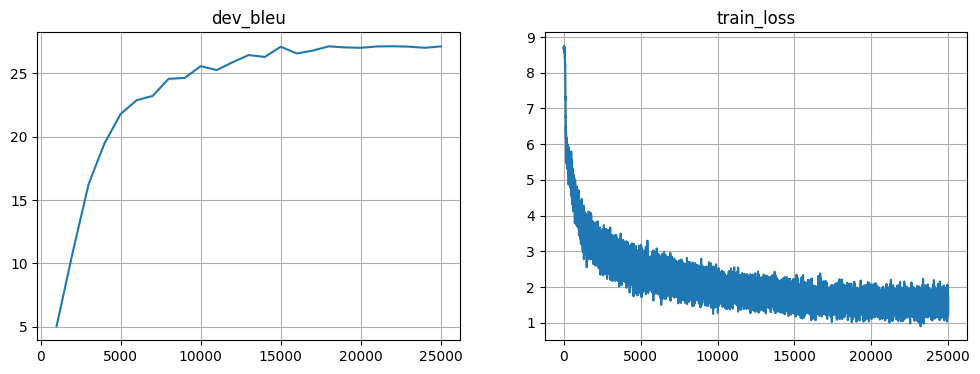

Mean loss=1.531


100%|██████████| 25000/25000 [1:26:58<00:00,  4.79it/s]

Current BLEU: 27.120, Best BLEU: 27.129
Training completed without early stopping
Final Best BLEU: 27.129


In [ ]:
best_bleu = 0.0
no_improvement_steps = 0
patience = 5
model_save_path = "best_model.pt"
scheduler = get_cosine_schedule_with_warmup(
    optimizer=opt,
    num_warmup_steps=1000,
    num_training_steps=25000
)

for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()

    opt.step()
    scheduler.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 1000 == 0:
        current_bleu = compute_bleu(model, dev_inp, dev_out)
        metrics['dev_bleu'].append((step, current_bleu))

        if current_bleu > best_bleu:
            best_bleu = current_bleu
            no_improvement_steps = 0
            torch.save(model.state_dict(), model_save_path)
        else:
            no_improvement_steps += 1

        if no_improvement_steps >= patience:
            print(f"\nEarly stopping at step {step}. Best BLEU: {best_bleu:.3f}")
            model.load_state_dict(torch.load(model_save_path))
            break

        # Визуализация
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print(f"Mean loss={np.mean(metrics['train_loss'][-10:], axis=0)[1]:.3f}", flush=True)
        print(f"Current BLEU: {current_bleu:.3f}, Best BLEU: {best_bleu:.3f}")

if no_improvement_steps < patience:
    print("Training completed without early stopping")
    print(f"Final Best BLEU: {best_bleu:.3f}")

In [ ]:
compute_bleu(model, dev_inp, dev_out)

27.119656594527363

**Как мы видим - благодаря нашим усилиям нам удалось улучшить метрику BLEU до значения 27 (было 24). Теперь давайте протестируем работу нашей модели в задаче машинного перевода**

In [18]:
model = AttentiveModel(inp_voc, out_voc).to(device)

checkpoint = torch.load("best_model.pt", map_location=device)
model.load_state_dict(checkpoint)

model.eval()

AttentiveModel(
  (emb_inp): Embedding(9927, 64)
  (emb_out): Embedding(9538, 64)
  (enc0): GRU(64, 128, num_layers=2, batch_first=True, bidirectional=True)
  (dec_start): Linear(in_features=256, out_features=128, bias=True)
  (dec0): GRUCell(320, 128)
  (logits): Linear(in_features=128, out_features=9538, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=256, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [25]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line.replace('@@ ', ''))
    print(trans_line.replace('@@ ', ''))
    print()

в ванной комнате с ванной предоставляется фен .
the bathroom comes with a bathtub and a hairdryer .

на территории можно сыграть в дартс и сквош .
you can play tennis at treatdarts and darts .

апартаменты располагают гостиной зоной .
the accommodation features a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests may cook their own meals at the viirfully ó lane on the kitchen .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
there is 1 bedrooms and 1 or a bathroom with a cable / or shower , as well as a kitchen with an oven and microwave .

ужин для гостей приготовят в ресторане ronnie ' s wings & oyster bar .
at swood ’ s restaurant ’ s comfort suites you will find a restaurant .

